In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re
from functools import partial

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [3]:
url = 'root://eosuser.cern.ch/'

In [4]:
f_pattern = '/eos/user/e/ekoenig/4BAnalysis/CMSSW_12_5_0/src/PhysicsTools/NanoHH4b/run/jobs_sig_{pairing}_2018_0L/mc/GluGluToHHTo4B_node_cHHH1_TuneCP5_13TeV-powheg-pythia8_1_tree.root'

f_sig_mindiag = f_pattern.format(pairing='mindiag')
f_sig_feynnet = f_pattern.format(pairing='feynnet')

sig_mindiag = Tree([f'{url}{f_sig_mindiag}'], use_gen=False, treename='Events', normalization='Runs:genEventCount', sample='GluGluToHHTo4B - MinDiag', color='blue')
sig_feynnet = Tree([f'{url}{f_sig_feynnet}'], use_gen=False, treename='Events', normalization='Runs:genEventCount', sample='GluGluToHHTo4B - FeynNet', color='red')

signal = ObjIter([sig_mindiag, sig_feynnet])

100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


In [5]:
f_pattern = '/eos/user/e/ekoenig/Ntuples/NanoHH4b/bkg_{pairing}_2018_0L/mc/QCD*.root'

f_bkg_mindiag = f_pattern.format(pairing='mindiag')
f_bkg_feynnet = f_pattern.format(pairing='feynnet')


In [6]:

bkg_mindiag = Tree( fc.fs.cernbox.glob(f_bkg_mindiag, with_path=True), use_gen=False, treename='Events', normalization='Runs:genEventCount', sample='Bkg - MinDiag', color='lightgrey')
bkg_feynnet = Tree(fc.fs.cernbox.glob(f_bkg_feynnet, with_path=True), use_gen=False, treename='Events', normalization='Runs:genEventCount', sample='Bkg - FeynNet', color='thistle')

bkg = ObjIter([bkg_mindiag, bkg_feynnet])

100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


In [7]:
kwargs = dict(
    legend=True,
)

100%|██████████| 2/2 [00:13<00:00,  6.87s/it]


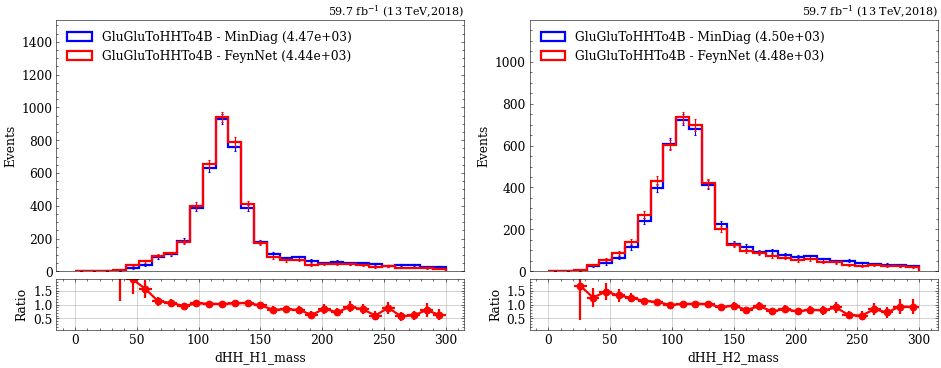

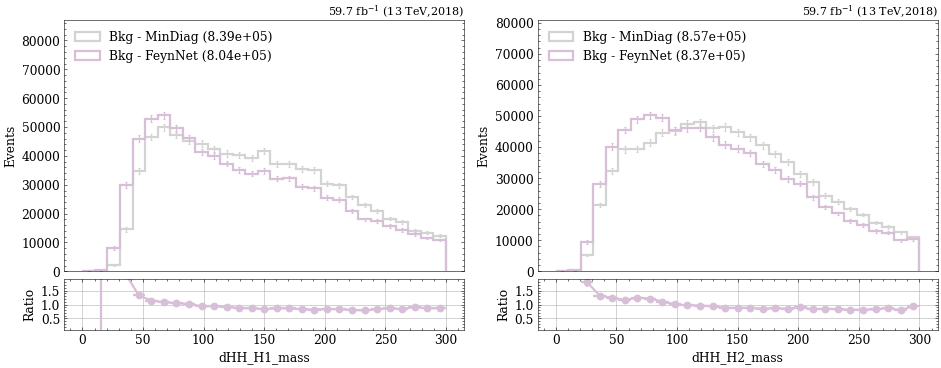

In [8]:
study.quick(
    signal,
    varlist=['dHH_H1_mass','dHH_H2_mass'],
    binlist=[(0,300,30)]*2,
    ratio=True, r_inv=True,
    **kwargs
)

study.quick(
    bkg, stacked=False,
    varlist=['dHH_H1_mass','dHH_H2_mass'],
    binlist=[(0,300,30)]*2,
    ratio=True, r_inv=True,
    **kwargs
)


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


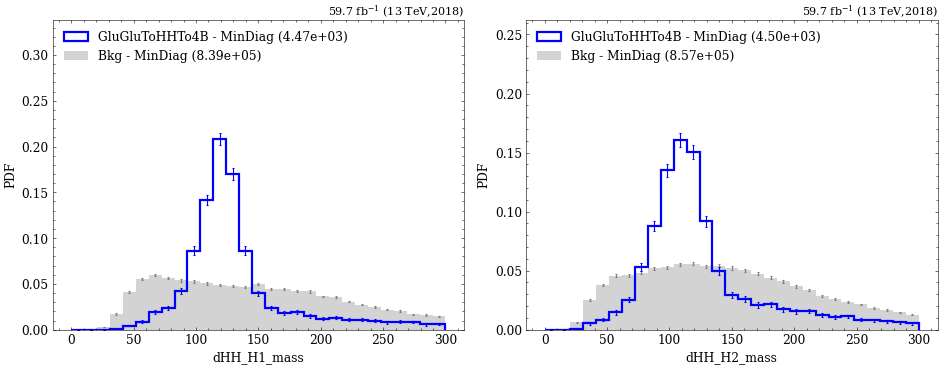

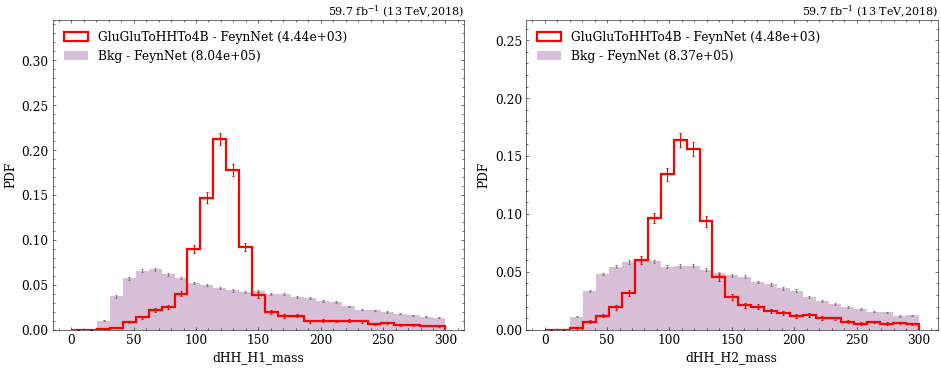

In [9]:
study.quick(
    signal[[0]]+bkg[[0]],
    varlist=['dHH_H1_mass','dHH_H2_mass'],
    binlist=[(0,300,30)]*2,
    efficiency=True,
    **kwargs
)

study.quick(
    signal[[1]]+bkg[[1]],
    varlist=['dHH_H1_mass','dHH_H2_mass'],
    binlist=[(0,300,30)]*2,
    efficiency=True,
    **kwargs
)

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


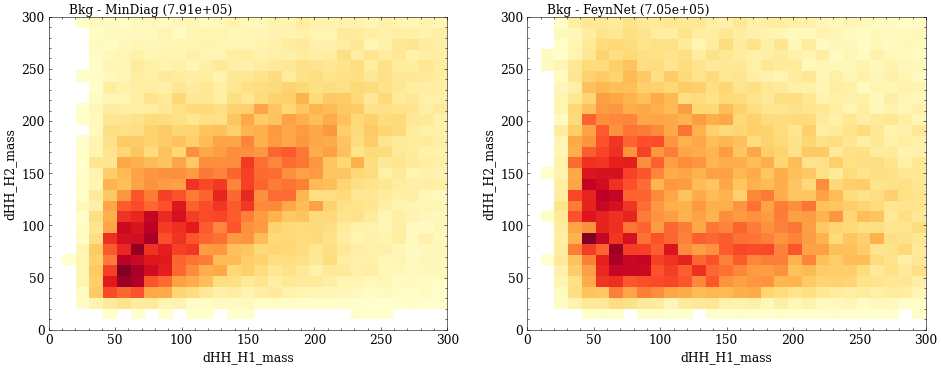

In [10]:
study.quick2d(
    bkg, stacked=False,
    varlist=['dHH_H1_mass','dHH_H2_mass'],
    binlist=[(0,300,30)]*2,
    **kwargs
)

In [13]:
@cache_variable
def n_loose_btag(t):
    nL = t.ak4_h1b1_btag_L + t.ak4_h1b2_btag_L + t.ak4_h2b1_btag_L + t.ak4_h2b2_btag_L
    
    return ak.values_astype(nL, np.int32)


In [14]:
@cache_variable(bins=(0,100,30))
def h_dm(t):
    return np.sqrt( (t.dHH_H1_mass - 125)**2 + (t.dHH_H2_mass - 125)**2 )

In [25]:
bdt_kwargs = dict(
    features=['dHH_H1_pt','dHH_H2_pt'],
    a=lambda t : (h_dm(t) < 25) & (n_loose_btag(t) == 4),
    b=lambda t : (h_dm(t) < 25) & (n_loose_btag(t) == 3),
    c=lambda t : (h_dm(t) > 25) & (h_dm(t) < 50) & (n_loose_btag(t) == 4),
    d=lambda t : (h_dm(t) > 25) & (h_dm(t) < 50) & (n_loose_btag(t) == 3),
)

mindiag_bdt = ABCD(**bdt_kwargs)
feynnet_bdt = ABCD(**bdt_kwargs)

In [43]:
bkg.apply(mindiag_bdt.print_yields)

       --- ABCD Bkg - MinDiag Yields ---        
Total: 3.09e+00 (19.42%)                        
SR   : 8.35e-01 (5.25%)                         
CR   : 2.26e+00 (14.17%)                        
------------------------------------------------
|           A          |           B           |
|       2.72e-01       |       5.63e-01        |
|        1.71%         |        3.54%          |
------------------------------------------------
|           C          |           D           |
|       7.44e-01       |       1.51e+00        |
|        4.68%         |        9.50%          |
------------------------------------------------
       --- ABCD Bkg - FeynNet Yields ---        
Total: 1.84e+00 (11.55%)                        
SR   : 3.80e-01 (2.39%)                         
CR   : 1.46e+00 (9.16%)                         
------------------------------------------------
|           A          |           B           |
|       1.14e-01       |       2.66e-01        |
|        0.72%      

[None, None]

100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


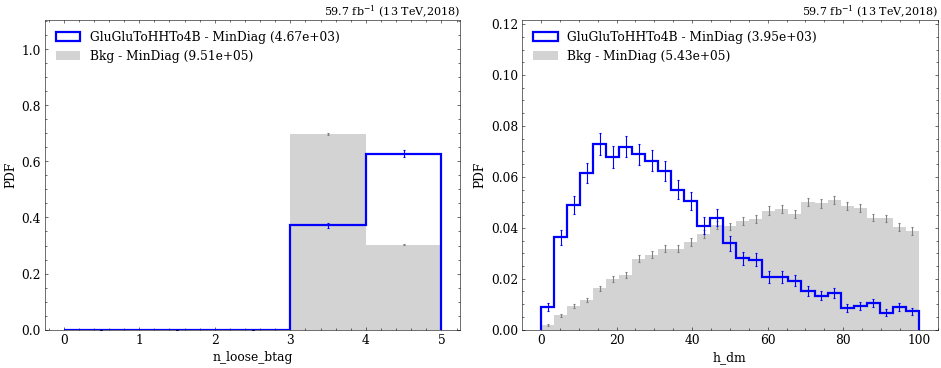

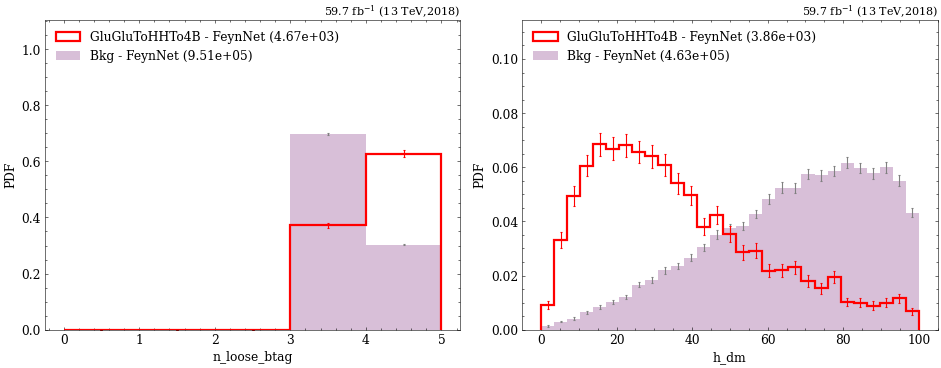

In [26]:
study.quick(
    signal[[0]]+bkg[[0]],
    varlist=[n_loose_btag, h_dm],
    efficiency=True,
    **kwargs,
)

study.quick(
    signal[[1]]+bkg[[1]],
    varlist=[n_loose_btag, h_dm],
    efficiency=True,
    **kwargs,
)

100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


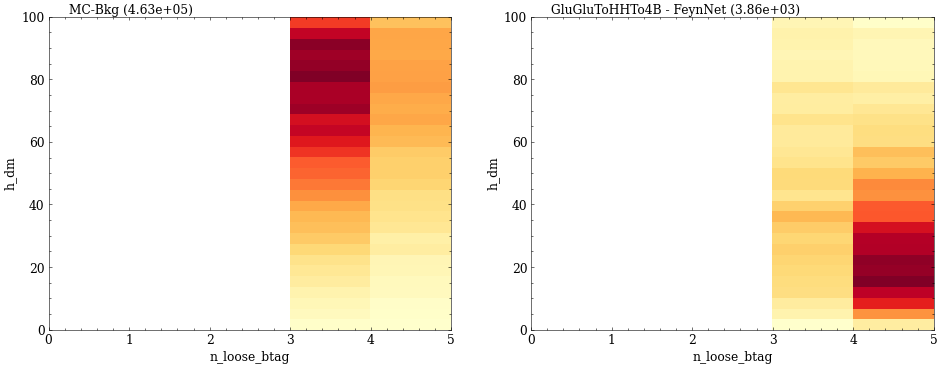

In [36]:
study.quick2d(
    signal[[1]]+bkg[[1]],
    varlist=[n_loose_btag, h_dm],
    efficiency=True,
    **kwargs,
)

In [37]:
varinfo.dHH_HH_mass = dict(bins=(200,1800,30))

100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


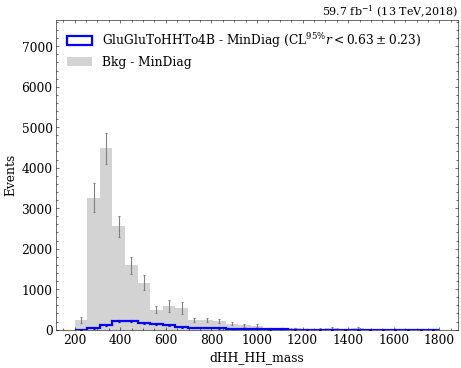

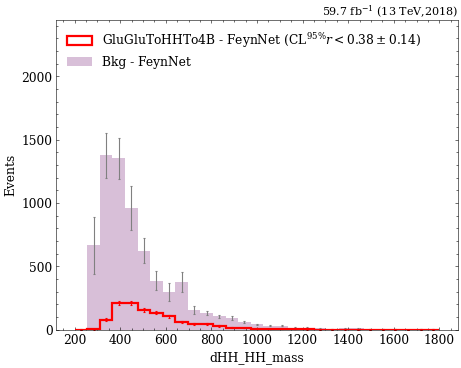

In [38]:
study.quick(
    signal[[0]]+bkg[[0]],
    masks=mindiag_bdt.a,
    varlist=['dHH_HH_mass'],
    legend=True,
    limits=True,
)

study.quick(
    signal[[1]]+bkg[[1]],
    masks=feynnet_bdt.a,
    varlist=['dHH_HH_mass'],
    legend=True,
    limits=True,
)

In [39]:
def get_yields(t, f_mask):
    weights = t.scale
    mask = f_mask(t)
    return ak.sum(weights[mask])

bkg_yields = bkg.apply(partial(get_yields, f_mask=feynnet_bdt.a)).npy
sig_yields = signal.apply(partial(get_yields, f_mask=feynnet_bdt.a)).npy

In [40]:
soverb = sig_yields / bkg_yields

soverb[1] / soverb[0]

2.2702744367096286

In [41]:
mindiag_bdt.train(bkg[[0]])
mindiag_bdt.print_results(bkg[[0]])

... fetching features
... splitting features
... calculating k factor
... fitting reweighter
--- ABCD Results ---
k = 4.926e-01
 (k*b)/a-1 = 2.07%
BDT(b)/a-1 = 2.79%



100%|██████████| 1/1 [00:00<00:00, 16.16it/s]


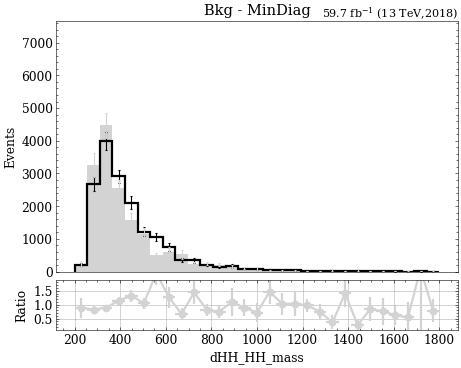

In [42]:
study.quick(
    bkg[[0,0]], stacked=False,
    h_histtype=['step','stepfilled'],
    h_color=['black','lightgrey'],
    masks=[mindiag_bdt.b, mindiag_bdt.a],
    scale=[mindiag_bdt.scale_tree, None],
    varlist=['dHH_HH_mass'],
    title=bkg[0].sample,
    ratio=True,
)

In [95]:
feynnet_bdt.train(bkg[[1]])
feynnet_bdt.print_results(bkg[[1]])

... fetching features
... splitting features
... calculating k factor
... fitting reweighter
--- ABCD Results ---
k = 4.830e-01
 (k*b)/a-1 = 12.94%
BDT(b)/a-1 = 11.19%



100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


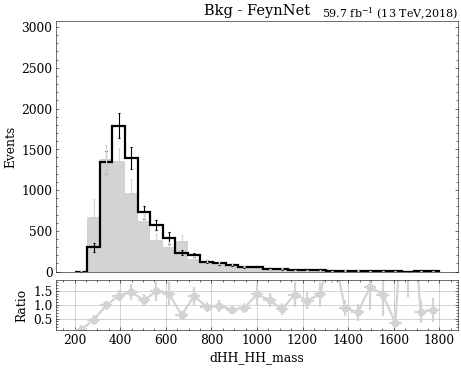

In [103]:
study.quick(
    bkg[[1,1]], stacked=False,
    h_histtype=['step','stepfilled'],
    h_color=['black','lightgrey'],
    masks=[feynnet_bdt.b, feynnet_bdt.a],
    scale=[feynnet_bdt.reweight_tree, None],
    varlist=['dHH_HH_mass'],
    title=bkg[1].sample,
    ratio=True,
)

100%|██████████| 1/1 [00:08<00:00,  8.40s/it]


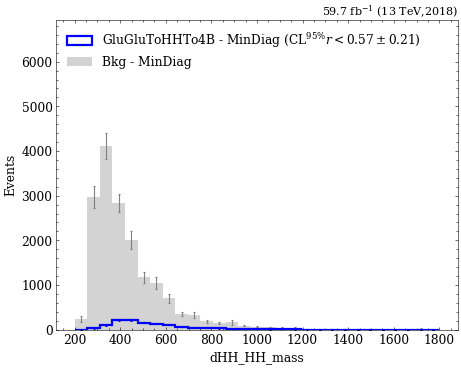

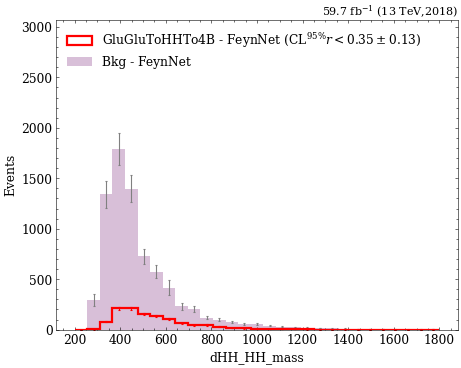

In [104]:
study.quick(
    signal[[0]]+bkg[[0]],
    masks=[mindiag_bdt.a, mindiag_bdt.b],
    scale=[None, mindiag_bdt.reweight_tree],
    varlist=['dHH_HH_mass'],
    legend=True,
    limits=True,
)

study.quick(
    signal[[1]]+bkg[[1]],
    masks=[feynnet_bdt.a, feynnet_bdt.b],
    scale=[None, feynnet_bdt.reweight_tree],
    varlist=['dHH_HH_mass'],
    legend=True,
    limits=True,
)